In [1]:
import kagglehub
path1 = "/kaggle/input/ham10000-lesion-segmentations"
path2 ="/kaggle/input/skin-cancer-mnist-ham10000"
print("Path to dataset files:", path1)
print("Path to dataset files:", path2)

Path to dataset files: /kaggle/input/ham10000-lesion-segmentations
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [2]:
import os
os.listdir(path1)
os.listdir(os.path.join(path1, "HAM10000_segmentations_lesion_tschandl"))
os.listdir(path2)
os.listdir(os.path.join(path2, "ham10000_images_part_2"))

['ISIC_0030912.jpg',
 'ISIC_0030585.jpg',
 'ISIC_0033697.jpg',
 'ISIC_0030062.jpg',
 'ISIC_0031213.jpg',
 'ISIC_0031317.jpg',
 'ISIC_0033841.jpg',
 'ISIC_0033096.jpg',
 'ISIC_0031252.jpg',
 'ISIC_0029645.jpg',
 'ISIC_0032893.jpg',
 'ISIC_0033414.jpg',
 'ISIC_0031422.jpg',
 'ISIC_0030032.jpg',
 'ISIC_0033903.jpg',
 'ISIC_0032809.jpg',
 'ISIC_0031479.jpg',
 'ISIC_0030506.jpg',
 'ISIC_0031986.jpg',
 'ISIC_0033624.jpg',
 'ISIC_0029352.jpg',
 'ISIC_0032582.jpg',
 'ISIC_0033152.jpg',
 'ISIC_0033974.jpg',
 'ISIC_0031417.jpg',
 'ISIC_0029889.jpg',
 'ISIC_0033788.jpg',
 'ISIC_0032651.jpg',
 'ISIC_0034221.jpg',
 'ISIC_0029989.jpg',
 'ISIC_0031785.jpg',
 'ISIC_0033401.jpg',
 'ISIC_0030924.jpg',
 'ISIC_0032208.jpg',
 'ISIC_0030148.jpg',
 'ISIC_0031280.jpg',
 'ISIC_0031059.jpg',
 'ISIC_0030551.jpg',
 'ISIC_0030896.jpg',
 'ISIC_0032463.jpg',
 'ISIC_0032929.jpg',
 'ISIC_0033366.jpg',
 'ISIC_0031156.jpg',
 'ISIC_0029806.jpg',
 'ISIC_0029427.jpg',
 'ISIC_0030537.jpg',
 'ISIC_0029690.jpg',
 'ISIC_003231

In [3]:
import pandas as pd
import os

metadata_path = os.path.join(path2, "HAM10000_metadata.csv")
metadata = pd.read_csv(metadata_path)

print(metadata.head())
print(metadata.columns)


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')


In [4]:
import os
import pandas as pd

mask_dir = os.path.join(path1, "HAM10000_segmentations_lesion_tschandl")

img_dir1 = os.path.join(path2, "HAM10000_images_part_1")
img_dir2 = os.path.join(path2, "HAM10000_images_part_2")


image_paths = {}
for folder in [img_dir1, img_dir2]:
    for file in os.listdir(folder):
        image_id = file.split(".")[0]
        image_paths[image_id] = os.path.join(folder, file)

data = []

for mask_file in os.listdir(mask_dir):
    if mask_file.endswith(".png"):
        image_id = mask_file.replace("_segmentation", "").replace(".png", "")
        mask_path = os.path.join(mask_dir, mask_file)


        img_path = image_paths.get(image_id, None)

        label_row = metadata[metadata["image_id"] == image_id]
        label = label_row["dx"].values[0] if not label_row.empty else None

        data.append({
            "image_id": image_id,
            "image_path": img_path,
            "mask_path": mask_path,
            "label": label
        })

df = pd.DataFrame(data)

print(df.head())
print("Number of attached images:", len(df))

df.to_csv("ham10000_image_mask_label.csv", index=False)


       image_id                                         image_path  \
0  ISIC_0033034  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1  ISIC_0026058  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2  ISIC_0031698  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3  ISIC_0032330  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4  ISIC_0030246  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                                           mask_path label  
0  /kaggle/input/ham10000-lesion-segmentations/HA...   mel  
1  /kaggle/input/ham10000-lesion-segmentations/HA...    nv  
2  /kaggle/input/ham10000-lesion-segmentations/HA...   bcc  
3  /kaggle/input/ham10000-lesion-segmentations/HA...   bkl  
4  /kaggle/input/ham10000-lesion-segmentations/HA...   mel  
Number of attached images: 10015


In [5]:
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm


output_dir = "yolo_dataset"
train_img_dir = os.path.join(output_dir, "train", "images")
train_lbl_dir = os.path.join(output_dir, "train", "labels")
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)


split_ratio = 0.8
image_ids = df["image_id"].tolist()
np.random.shuffle(image_ids)
split_index = int(len(image_ids) * split_ratio)
train_ids = set(image_ids[:split_index])
val_ids = set(image_ids[split_index:])


def mask_to_bbox(mask):
    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)
    return x, y, w, h


def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2] / 2.0) * dw
    y = (box[1] + box[3] / 2.0) * dh
    w = box[2] * dw
    h = box[3] * dh
    return x, y, w, h


for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["image_path"]
    mask_path = row["mask_path"]
    image_id = row["image_id"]


    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        continue


    if np.sum(mask) == 0:
        continue  

    x, y, w, h = mask_to_bbox(mask)


    yolo_box = convert_to_yolo((img.shape[1], img.shape[0]), (x, y, w, h))

   
    if image_id in train_ids:
        img_out_dir = train_img_dir
        lbl_out_dir = train_lbl_dir
    else:
        img_out_dir = train_img_dir.replace("train", "val")
        lbl_out_dir = train_lbl_dir.replace("train", "val")
        os.makedirs(img_out_dir, exist_ok=True)
        os.makedirs(lbl_out_dir, exist_ok=True)


    shutil.copy(img_path, os.path.join(img_out_dir, f"{image_id}.jpg"))


    with open(os.path.join(lbl_out_dir, f"{image_id}.txt"), "w") as f:
        f.write(f"0 {' '.join(map(str, yolo_box))}\n")

print("YOLO is generated from masks...")


100%|██████████| 10015/10015 [03:47<00:00, 43.95it/s]

YOLO is generated from masks...


In [6]:
yaml_content = """train: /kaggle/working/yolo_dataset/train/images
val: /kaggle/working/yolo_dataset/val/images
nc: 1
names: ["lesion"]
"""

with open("/kaggle/working/yolo_dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created with correct YAML formatting")


data.yaml created with correct YAML formatting


In [7]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [8]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
modely = YOLO('yolov8s.pt')

results = modely.train(
    data="/kaggle/working/yolo_dataset/data.yaml",
    epochs=30,
    imgsz=640,
    batch=32,
    device=0,
    amp=True,
    cache=True,
    freeze=5
)

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2022.0±1221.6 MB/s, size: 305.9 KB)


train: Scanning /kaggle/working/yolo_dataset/train/labels... 8012 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8012/8012 [00:05<00:00, 1590.52it/s]


train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (6.9GB RAM): 100%|██████████| 8012/8012 [00:26<00:00, 305.55it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 68.1±30.1 MB/s, size: 273.4 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels... 2003 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2003/2003 [00:03<00:00, 572.10it/s]

val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.7GB RAM): 100%|██████████| 2003/2003 [00:06<00:00, 298.36it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.14G     0.9851      1.005      1.382         35        640: 100%|██████████| 251/251 [01:30<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]

                   all       2003       2003      0.789      0.783      0.827      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.34G     0.9569     0.6931      1.338         27        640: 100%|██████████| 251/251 [01:33<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]

                   all       2003       2003      0.922      0.917      0.959      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.37G     0.9033     0.6276      1.299         32        640: 100%|██████████| 251/251 [01:33<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]

                   all       2003       2003      0.946      0.936      0.972      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.41G     0.8744     0.5884      1.273         30        640: 100%|██████████| 251/251 [01:36<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]

                   all       2003       2003      0.939      0.938      0.976      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.44G     0.8418     0.5532      1.249         24        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]

                   all       2003       2003      0.954      0.944      0.979      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.48G     0.8132     0.5293      1.232         23        640: 100%|██████████| 251/251 [01:37<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       2003       2003      0.951      0.952       0.98      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.51G     0.7966     0.5152      1.219         25        640: 100%|██████████| 251/251 [01:36<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]

                   all       2003       2003      0.952       0.95      0.983      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.55G     0.7703      0.491      1.204         29        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       2003       2003      0.968      0.955      0.985      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.58G     0.7639     0.4844      1.197         27        640: 100%|██████████| 251/251 [01:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]

                   all       2003       2003      0.963      0.959      0.984      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.62G     0.7456     0.4686      1.189         28        640: 100%|██████████| 251/251 [01:36<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]

                   all       2003       2003      0.967      0.965      0.988      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.65G     0.7418     0.4631      1.186         27        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

                   all       2003       2003      0.961      0.971      0.986      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.69G      0.731     0.4538      1.176         28        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]

                   all       2003       2003      0.955      0.962      0.984      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.73G     0.7199     0.4491      1.171         21        640: 100%|██████████| 251/251 [01:36<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]

                   all       2003       2003      0.966      0.965      0.985      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.76G     0.7208     0.4415      1.168         34        640: 100%|██████████| 251/251 [01:37<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       2003       2003      0.964      0.964      0.987      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.79G     0.7073     0.4301      1.162         35        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

                   all       2003       2003      0.979      0.964      0.989      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.83G     0.6923     0.4226      1.154         37        640: 100%|██████████| 251/251 [01:37<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]

                   all       2003       2003      0.973      0.965       0.99      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.87G     0.7022     0.4222      1.162         29        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.46it/s]

                   all       2003       2003      0.965      0.967      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       5.9G     0.6876     0.4096      1.147         32        640: 100%|██████████| 251/251 [01:37<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]

                   all       2003       2003      0.974       0.97       0.99      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.94G     0.6827     0.4065      1.147         27        640: 100%|██████████| 251/251 [01:37<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]

                   all       2003       2003      0.966      0.971      0.989      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.97G     0.6681     0.3965      1.138         25        640: 100%|██████████| 251/251 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

                   all       2003       2003      0.978      0.969      0.989      0.871


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.01G     0.5802     0.3087      1.104         12        640: 100%|██████████| 251/251 [01:37<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]

                   all       2003       2003      0.976      0.965       0.99      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.04G     0.5662      0.296      1.096         12        640: 100%|██████████| 251/251 [01:34<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

                   all       2003       2003      0.971      0.965      0.988      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.08G     0.5524     0.2887       1.09         12        640: 100%|██████████| 251/251 [01:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]

                   all       2003       2003      0.966      0.977       0.99      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.11G     0.5441     0.2811      1.079         12        640: 100%|██████████| 251/251 [01:35<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]

                   all       2003       2003      0.974      0.969      0.991       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.15G     0.5283     0.2658      1.067         12        640: 100%|██████████| 251/251 [01:36<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

                   all       2003       2003      0.979      0.971       0.99       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.18G     0.5185     0.2569      1.052         12        640: 100%|██████████| 251/251 [01:34<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]

                   all       2003       2003      0.973      0.969      0.991      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.22G     0.5112     0.2525      1.049         12        640: 100%|██████████| 251/251 [01:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]

                   all       2003       2003      0.976      0.976      0.992      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.25G     0.5002     0.2449      1.039         12        640: 100%|██████████| 251/251 [01:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       2003       2003      0.979      0.973      0.992      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.29G     0.4866     0.2361      1.034         12        640: 100%|██████████| 251/251 [01:35<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]

                   all       2003       2003      0.975      0.977      0.992       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.32G     0.4797     0.2311      1.026         12        640: 100%|██████████| 251/251 [01:36<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]

                   all       2003       2003      0.977      0.977      0.991       0.89



30 epochs completed in 0.913 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2003       2003      0.974      0.978      0.992      0.891
Speed: 0.1ms preprocess, 3.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


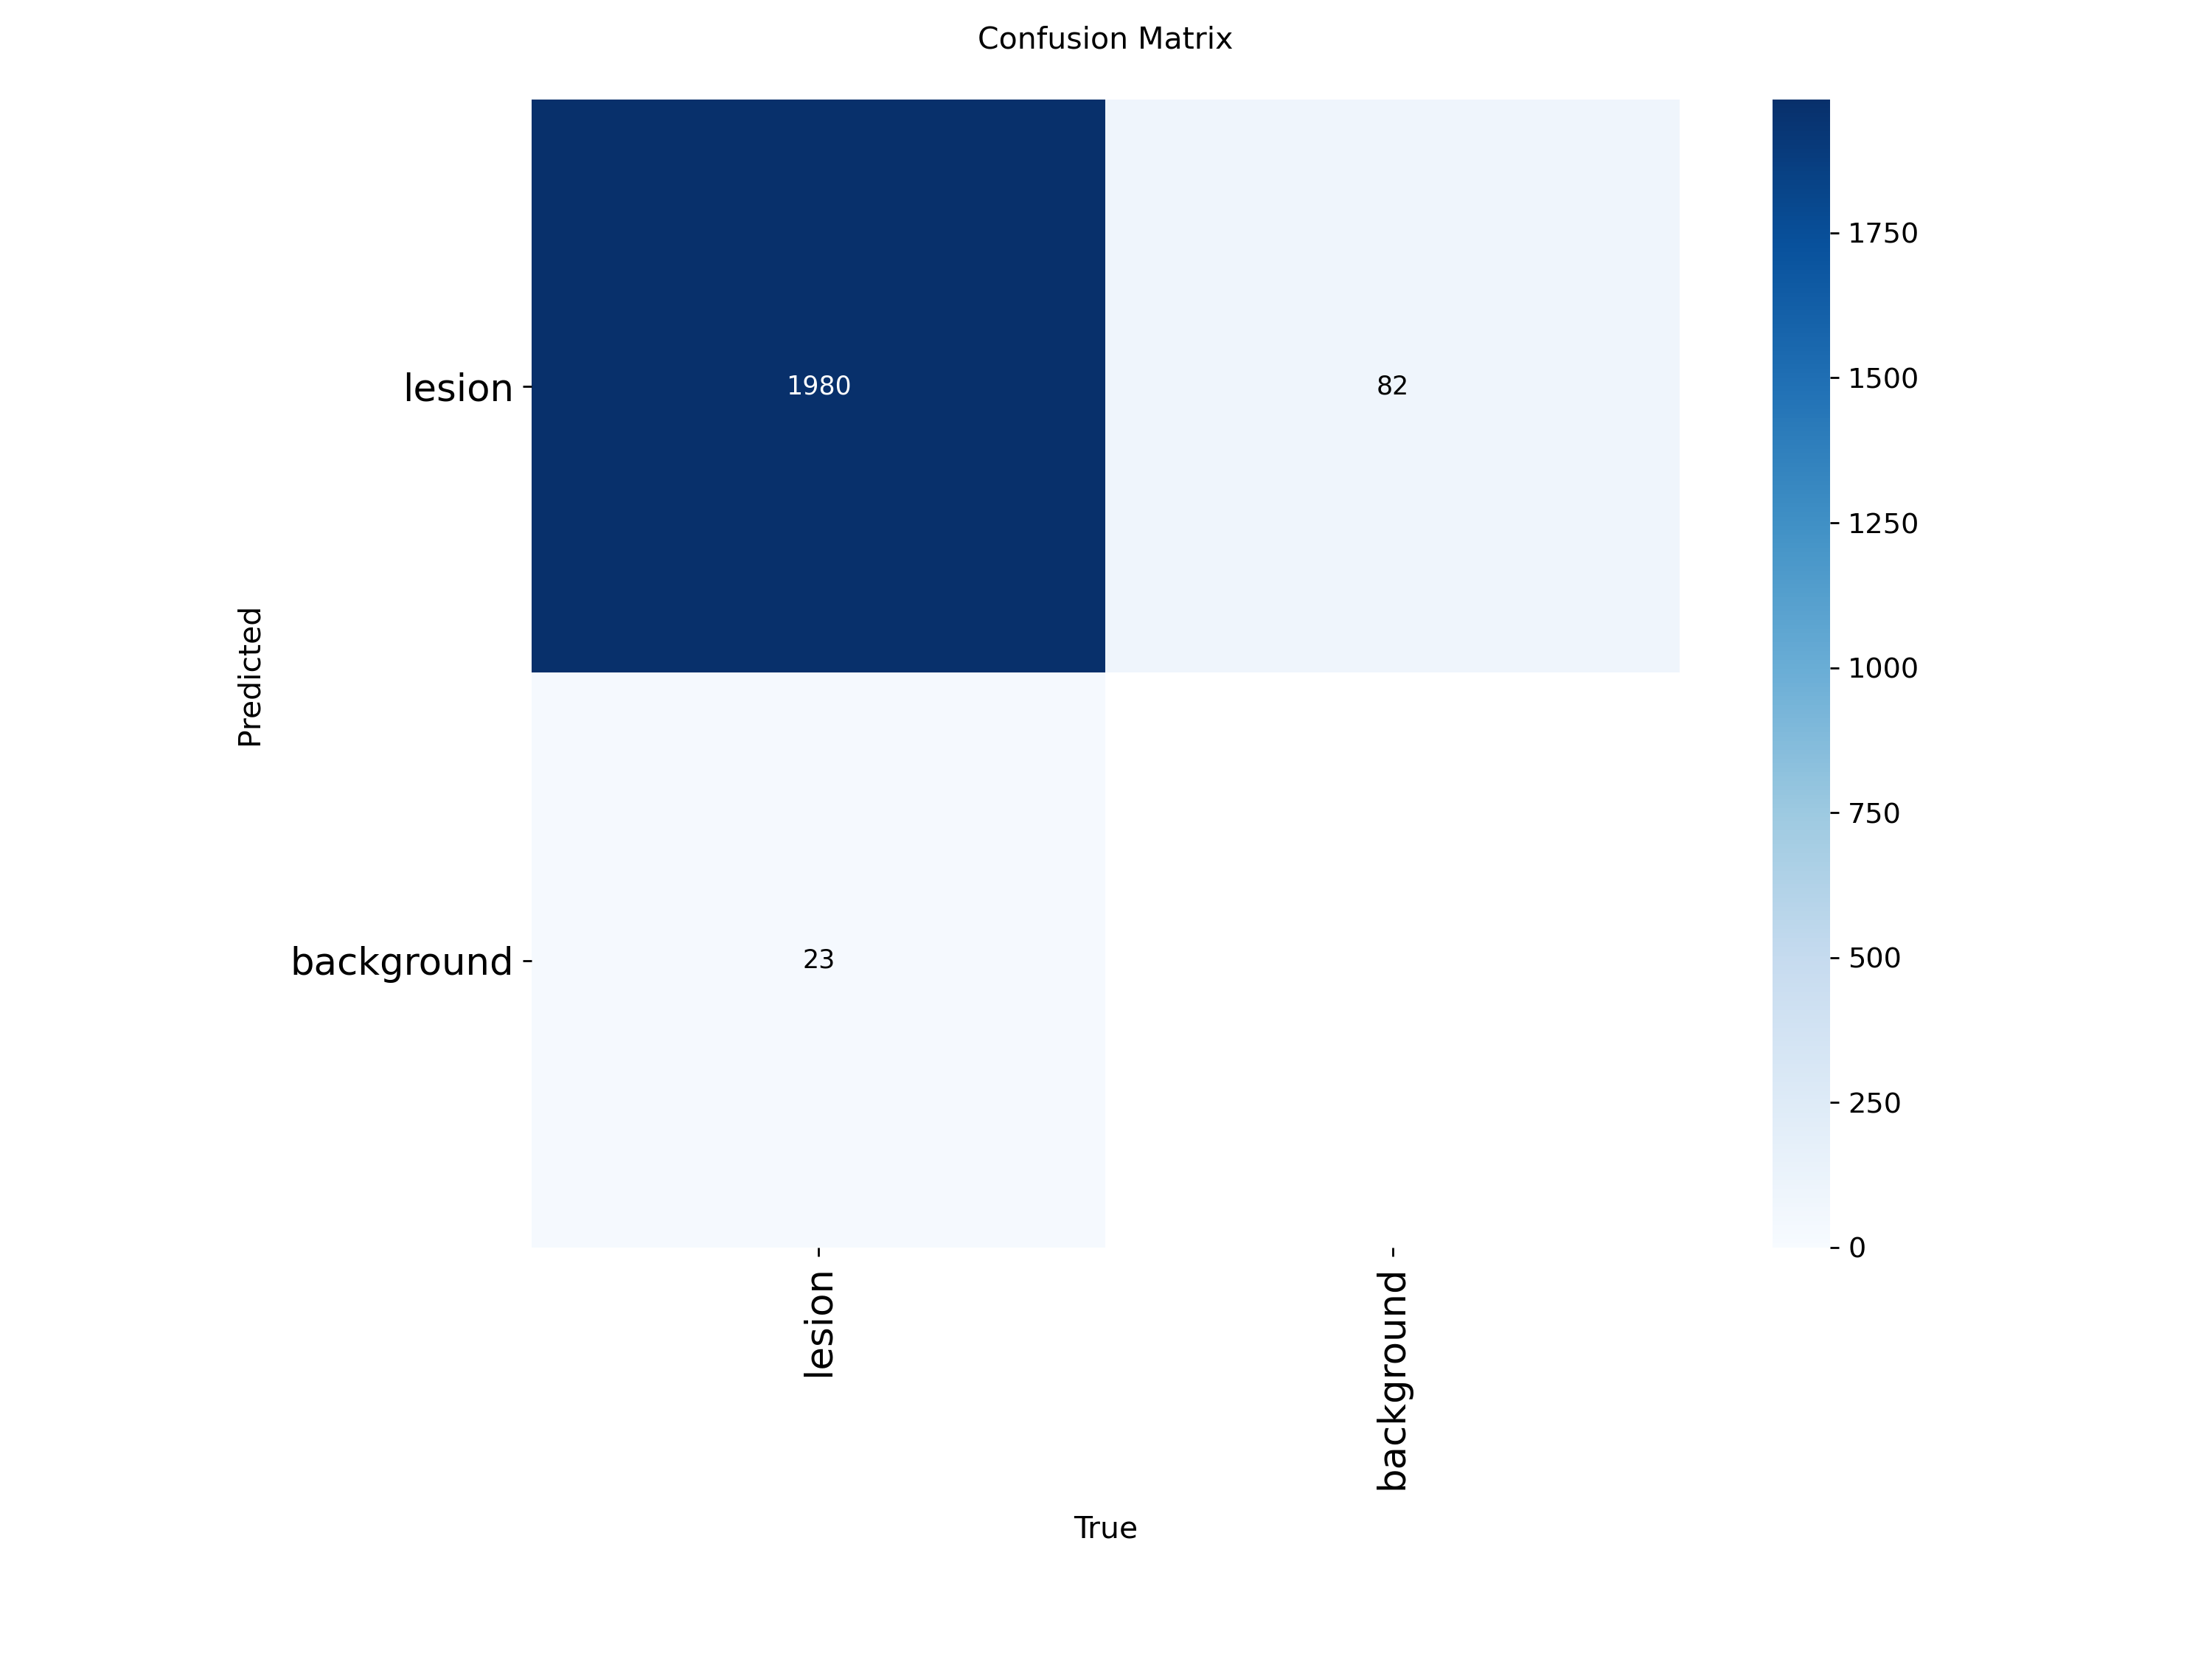

In [10]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/detect/train/confusion_matrix.png', width=700)

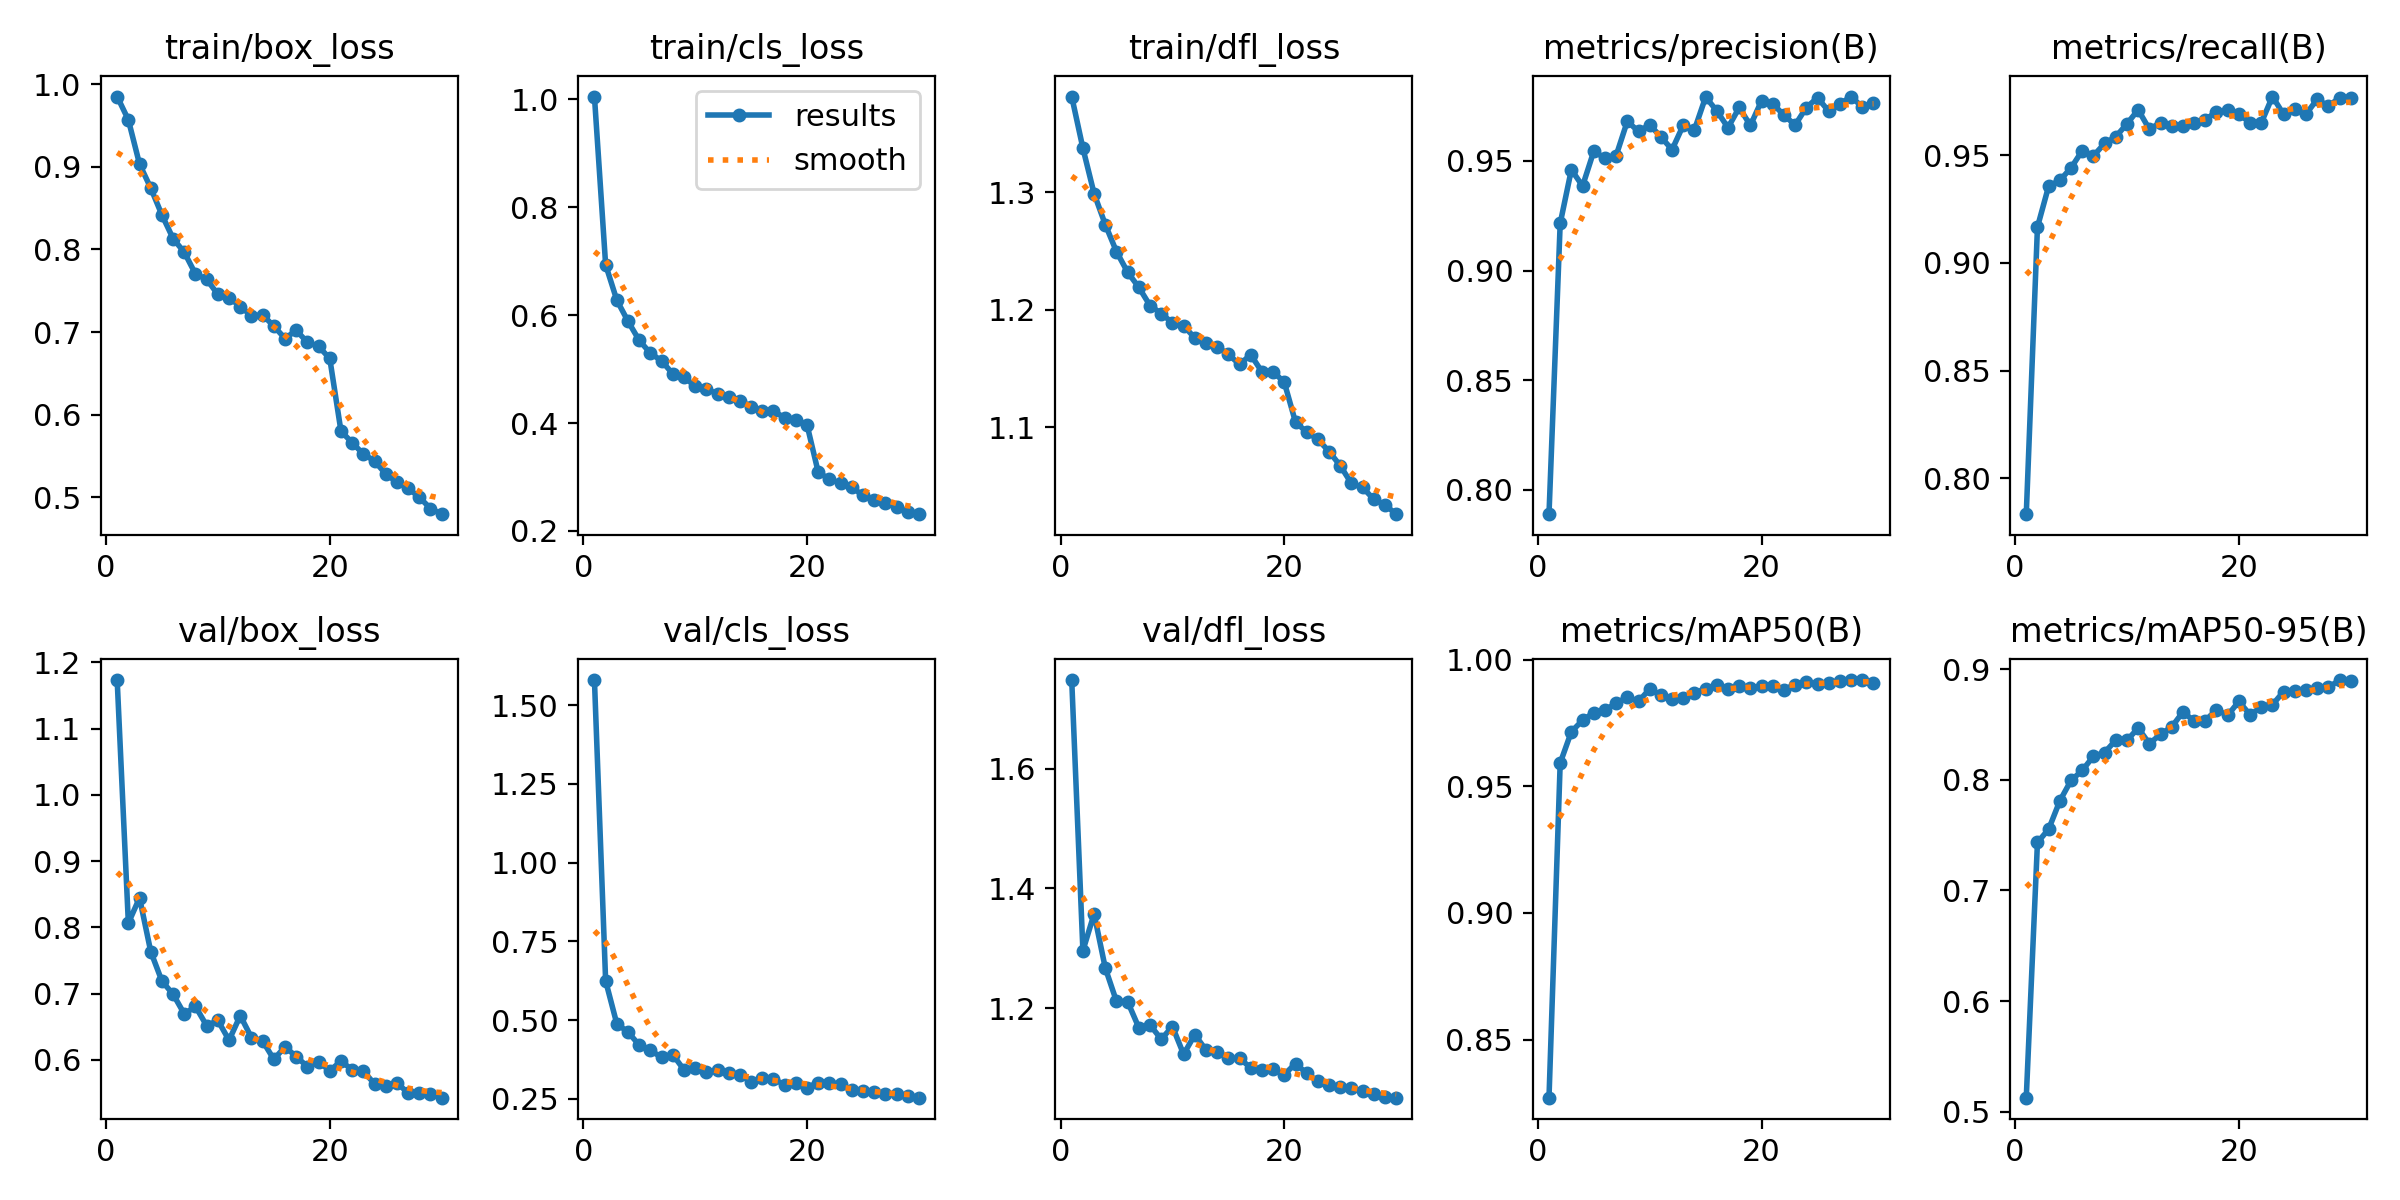

In [11]:
Image(filename='/kaggle/working/runs/detect/train/results.png', width=700)

In [12]:
import shutil
shutil.copy("/kaggle/working/runs/detect/train/weights/best.pt", "/kaggle/working/best_model.pt")

'/kaggle/working/best_model.pt'

In [13]:
modely = YOLO('/kaggle/input/yolov8-skin-lesion-model/best_model.pt')

In [14]:
import glob
import os

hamy = glob.glob(os.path.join("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2", "*.jpg"))

resultat = modely.predict(source=hamy[:12], save=True, conf=0.55)

from IPython.display import Image, display

pred_folder = resultat[0].save_dir


0: 480x640 1 lesion, 8.6ms
1: 480x640 1 lesion, 8.6ms
2: 480x640 1 lesion, 8.6ms
3: 480x640 1 lesion, 8.6ms
4: 480x640 1 lesion, 8.6ms
5: 480x640 1 lesion, 8.6ms
6: 480x640 1 lesion, 8.6ms
7: 480x640 1 lesion, 8.6ms
8: 480x640 1 lesion, 8.6ms
9: 480x640 1 lesion, 8.6ms
10: 480x640 1 lesion, 8.6ms
11: 480x640 1 lesion, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


In [15]:
from IPython.display import display, HTML

images_per_row = 4

image_paths = glob.glob(os.path.join(pred_folder, '*.jpg'))


html = ""
for i in range(0, len(image_paths), images_per_row):
    row_images = image_paths[i:i+images_per_row]
    html += "<div style='display: flex; gap: 10px; margin-bottom: 10px;'>"
    for img_path in row_images:
        html += f"<img src='{img_path}' style='width: 200px; height: auto;'/>"
    html += "</div>"

display(HTML(html))

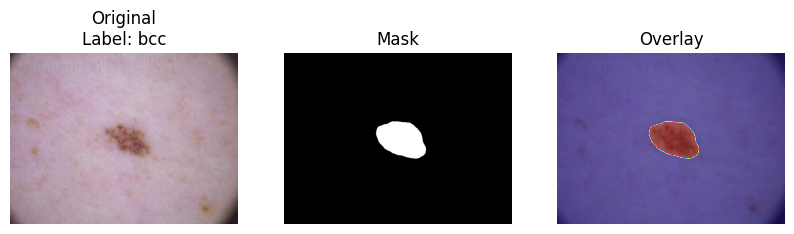

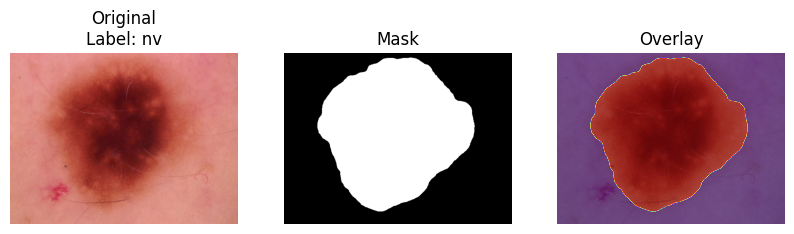

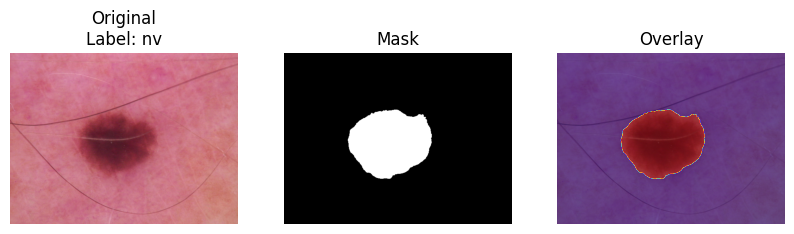

In [16]:
import matplotlib.pyplot as plt
import cv2
import random

sample = df.sample(3, random_state=42)

for i, row in sample.iterrows():

    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(f"Original\nLabel: {row['label']}")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.imshow(mask, cmap='jet', alpha=0.5)  # overlay mask
    plt.title("Overlay")
    plt.axis('off')

    plt.show()


In [17]:
import cv2
import numpy as np

IMG_SIZE = 128

def preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # normalize
    return img

def preprocess_mask(mask_path, img_size=IMG_SIZE):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask


In [18]:
images = []
masks = []

for _, row in df.iterrows():
    img = preprocess_image(row['image_path'])
    mask = preprocess_mask(row['mask_path'])

    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (10015, 128, 128, 3)
Masks shape: (10015, 128, 128, 1)


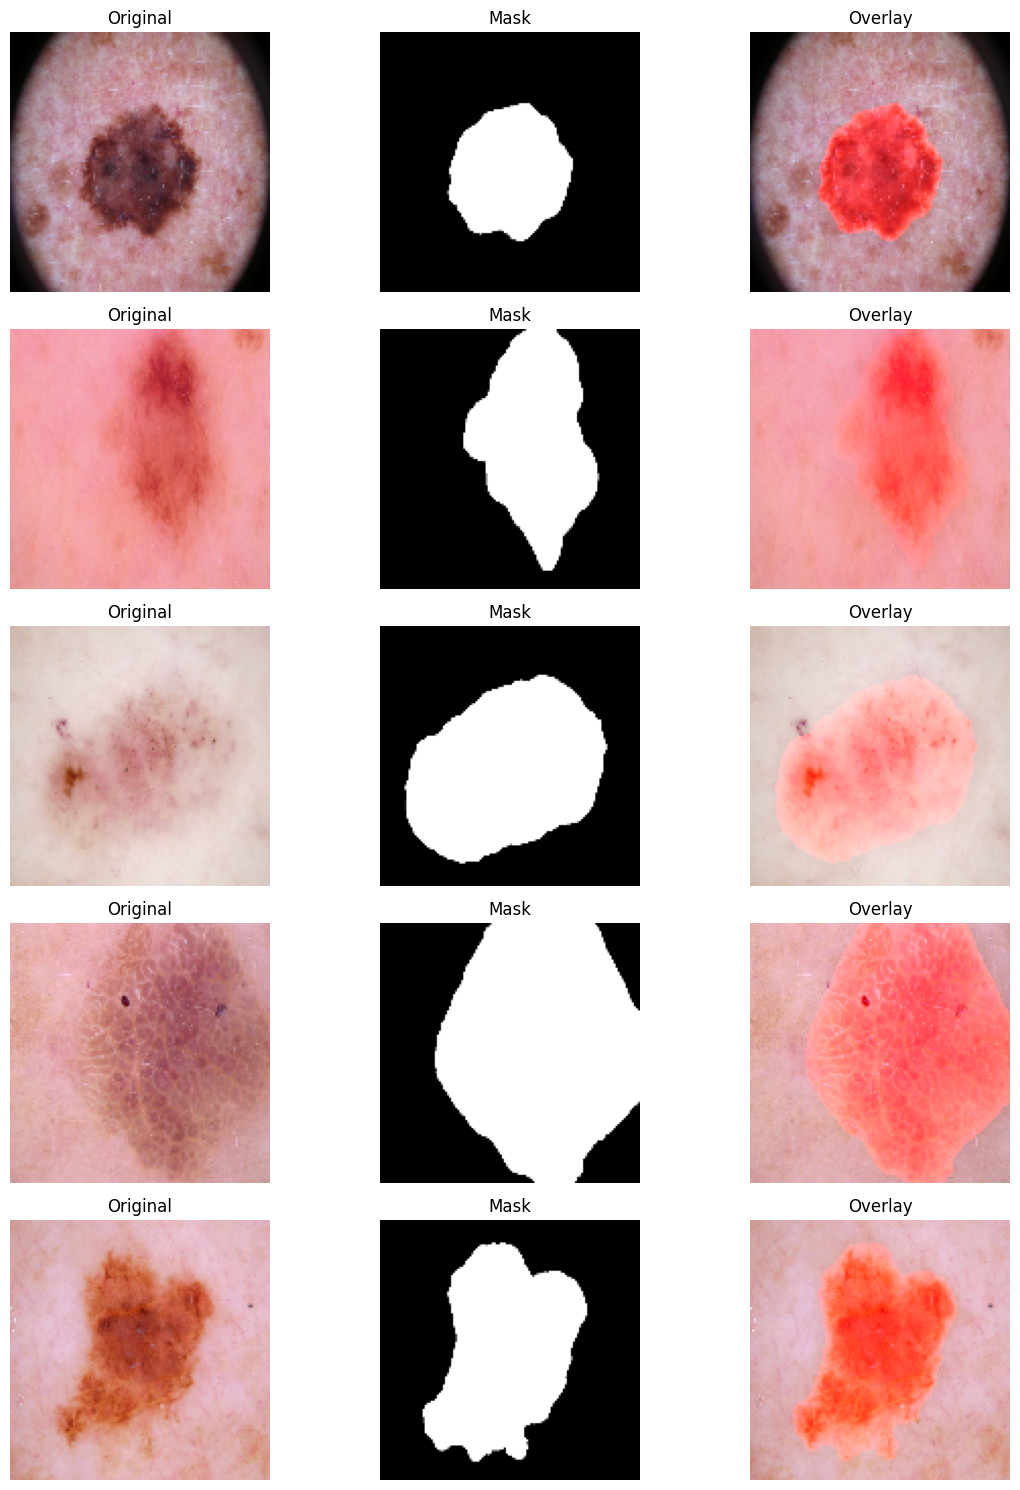

In [19]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_samples(images, masks, num=5):
    plt.figure(figsize=(12, num * 3))
    for i in range(num):
        # Original Image
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        # Mask
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        # Overlay
        plt.subplot(num, 3, i*3 + 3)
        overlay = (images[i] * 255).astype(np.uint8)  # Convert image to uint8
        mask_rgb = np.zeros_like(overlay)
        mask_rgb[:, :, 0] = masks[i].squeeze() * 255
        mask_rgb = mask_rgb.astype(np.uint8) # Convert mask to uint8
        overlay = cv2.addWeighted(overlay, 1, mask_rgb, 0.5, 0)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_samples(images, masks)

In [20]:
images = images / 255.0

In [21]:
masks = (masks > 0).astype(np.float32)